# Tutorial for calculating the reflectance of a polydisperse bulk film using Monte Carlo

In [1]:
%matplotlib inline
import numpy as np
import time
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
from structcol import phase_func_sphere as pfs
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.misc import factorial
import os
print(os.getcwd())

/home/stephenson/Repositories/structural-color


### Set parameters

In [6]:
# Properties of system
ntrajectories = 500         # number of trajectories for one microsphere
nevents =400                 # number of scattering events in each trajectory in a microsphere
ntrajectories_bulk = 1000    # number of trajectories to run in the bulk film
nevents_bulk = 400            # number of events to run in the bulk film
wavelengths = sc.Quantity(np.arange(400., 801.,10),'nm') # wavelengths at which to calculate reflectance
nanosphere_radius = sc.Quantity('0.125 um') # radius of the nanosphere
volume_fraction_microspheres = sc.Quantity(0.55,'') # volume fraction of the microspheres packed in a a nanosphere
volume_fraction_nanospheres = sc.Quantity(0.55, '') # volume fraction of the nanospheres packed in a microsphere
bulk_thickness = sc.Quantity('50 um') # thickness of the bulk film

# refractive indices
n_nanoparticle = ri.n('vacuum', wavelengths) # refractive index of nanoparticle
n_matrix = ri.n('fused silica', wavelengths) # refractive index of matrix
n_medium = ri.n('vacuum', wavelengths) # refractive index of medium outside the sample. 
n_matrix_bulk = n_medium
n_medium_bulk = ri.n('vacuum', wavelengths)

# params related to polydispersity calculations
num_radii = 3 # number of radii from which to sample, higher number takes longer but gives a more precise calculation
microsphere_radius_mean = sc.Quantity(10,'um')  # radius of the microsphere
pdi = 0.2

# Properties that should not need to be changed
z_low = sc.Quantity('0.0 um') # sets trajectories starting point
sns.set_style('white') # sets white plotting background

[  7.46661102   9.61519199  12.08931553] micrometer


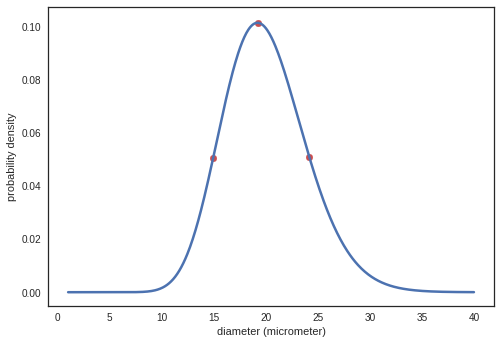

In [7]:
# calculate radius list to sample from

microsphere_radius = pfs.calc_rad_list(num_radii, microsphere_radius_mean, pdi, equal_spacing = False)
print(microsphere_radius)

### Calculate phase functions for a set of sphere diameters

In [19]:
p_microsphere = np.zeros((microsphere_radius.size, wavelengths.size, 200))
reflectance_microsphere = np.zeros(wavelengths.size)
lscat = sc.Quantity(np.zeros((microsphere_radius.size, wavelengths.size)),'um')

for j in range(microsphere_radius.size):
    # print radius to keep track of where we are in calculation
    print('radius: ' + str(microsphere_radius[j]))
    for i in range(wavelengths.size):

        # caculate the effective index of the sample
        n_sample = ri.n_eff(n_nanoparticle[i], n_matrix[i], volume_fraction_nanospheres)

        # Calculate the phase function and scattering and absorption coefficients from the single scattering model
        # (this absorption coefficient is of the scatterer, not of an absorber added to the system)
        p, mu_scat, mu_abs = mc.calc_scat(nanosphere_radius, n_nanoparticle[i], n_sample,
                                          volume_fraction_nanospheres, wavelengths[i])

        # Initialize the trajectories
        r0, k0, W0 = mc.initialize_sphere(nevents, ntrajectories, n_medium[i], n_sample, microsphere_radius[j])
        r0 = sc.Quantity(r0, 'um')
        k0 = sc.Quantity(k0, '')
        W0 = sc.Quantity(W0, '')

        # Create trajectories object
        trajectories = mc.Trajectory(r0, k0, W0)

        # Generate a matrix of all the randomly sampled angles first 
        sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

        # Create step size distribution
        step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)

        # Run photons
        trajectories.absorb(mu_abs, step)                         
        trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
        trajectories.move(step)

        # Calculate reflection and transmition 
        (refl_indices, trans_indices, 
        k1_refl, k1_trans, 
        norm_refl, norm_trans,
        refl_per_traj, trans_per_traj,
        reflectance_microsphere[i], transmittance_microsphere)\
                 = mc.calc_refl_trans_sphere(trajectories, n_medium[i], n_sample, microsphere_radius[j], 
                                             p, mu_abs, mu_scat, plot_exits = False, run_tir = False, 
                                             return_extra = True)

        # calculate the lscat of the microsphere for use in the bulk simulation
        lscat[j,i] = pfs.calc_lscat(refl_per_traj, trans_per_traj, trans_indices, 
                                  volume_fraction_nanospheres, microsphere_radius[j])

        # find the points on the sphere where trajectories exit
        x_inter, y_inter, z_inter = pfs.get_exit_pos(norm_refl, norm_trans, microsphere_radius[j])

        # calculate the probability density function as a function of nu, which depends on the scattering angle
        p_microsphere[j,i,:] = pfs.calc_pdf(x_inter, y_inter, z_inter, microsphere_radius[j], plot = False, phi_dependent = False)

radius: 0.125 micrometer


/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:360: RuntimeWarning: invalid value encountered in double_scalars
  return((x-x0)/(x1-x0)-(y-y0)/(y1-y0), (z-z0)/(z1-z0)-(y-y0)/(y1-y0), x**2 + y**2 + z**2-radius**2 )
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:360: RuntimeWarning: divide by zero encountered in double_scalars
  return((x-x0)/(x1-x0)-(y-y0)/(y1-y0), (z-z0)/(z1-z0)-(y-y0)/(y1-y0), x**2 + y**2 + z**2-radius**2 )
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:606: RuntimeWarning: invalid value encountered in true_divide
  k1 = k1/mag
/home/stephenson/Repositories/structural-color/structcol/montecarlo.py:628: RuntimeWarning: invalid value encountered in true_divide
  dot_z = np.nan_to_num(abs(select_z1-select_z0)/mag)
/home/stephenson/anaconda3/lib/python3.5/site-packages/Pint-0.7.2-py3.5.egg/pint/quantity.py:912: RuntimeWarning: invalid value encountered in greater


radius: 0.125 micrometer


### Sample distribution of microsphere radii

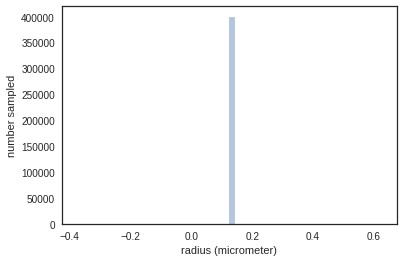

In [20]:
# sample
microsphere_rads_sampled = pfs.sample_radii(pdi, microsphere_radius, microsphere_radius_mean, ntrajectories_bulk,
                                         nevents_bulk)

# plot
sns.distplot(np.ndarray.flatten(microsphere_rads_sampled), kde = False)
#plt.xlim([0,20])
plt.ylabel('number sampled')
plt.xlabel('radius (' + str(microsphere_radius_mean.units) + ')')

### Calculate reflectance of bulk polydisperse film

In [21]:
reflectance_bulk_poly = np.zeros(wavelengths.size)
for i in range(wavelengths.size):
    
    # print the wavelength keep track of where we are in calculation 
    print('wavelength: ' + str(wavelengths[i]))

    # Initialize the trajectories
    r0, k0, W0 = mc.initialize(nevents_bulk, ntrajectories_bulk, n_medium_bulk[i], n_matrix_bulk[i])
    r0 = sc.Quantity(r0, 'um')
    W0 = sc.Quantity(W0, '')
    
    # Sample angles and calculate step size based on sampled radii
    sintheta, costheta, sinphi, cosphi, step, _, _ = pfs.sample_angles_step_poly(nevents_bulk, ntrajectories_bulk,
                                                            p_microsphere[:,i,:], 
                                                            microsphere_rads_sampled, microsphere_radius, lscat[:,i])

    # initialize first direction to be the last sampled angle 
    # (since last sample angle isn't used, this is equivalent to sampling another angle)
    k0[0,0,:] = sintheta[-1,:]*cosphi[-1,:]
    k0[1,0,:] = sintheta[-1,:]*sinphi[-1,:]
    k0[2,0,:] = costheta[-1,:]
    k0 = sc.Quantity(k0, '')
    
    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0)

    # Run photons
    #trajectories.absorb(mu_abs, step)                         
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
    trajectories.move(step)

    # calculate reflectance
    reflectance_bulk_poly[i], transmittance = mc.calc_refl_trans(trajectories, z_low, bulk_thickness, 
                                                               n_medium_bulk[i], n_matrix_bulk[i])

wavelength: 400.0 nanometer
wavelength: 410.0 nanometer
wavelength: 420.0 nanometer
wavelength: 430.0 nanometer
wavelength: 440.0 nanometer
wavelength: 450.0 nanometer
wavelength: 460.0 nanometer
wavelength: 470.0 nanometer
wavelength: 480.0 nanometer
wavelength: 490.0 nanometer
wavelength: 500.0 nanometer
wavelength: 510.0 nanometer
wavelength: 520.0 nanometer
wavelength: 530.0 nanometer
wavelength: 540.0 nanometer
wavelength: 550.0 nanometer
wavelength: 560.0 nanometer
wavelength: 570.0 nanometer
wavelength: 580.0 nanometer
wavelength: 590.0 nanometer
wavelength: 600.0 nanometer
wavelength: 610.0 nanometer
wavelength: 620.0 nanometer
wavelength: 630.0 nanometer
wavelength: 640.0 nanometer
wavelength: 650.0 nanometer
wavelength: 660.0 nanometer
wavelength: 670.0 nanometer
wavelength: 680.0 nanometer
wavelength: 690.0 nanometer
wavelength: 700.0 nanometer
wavelength: 710.0 nanometer
wavelength: 720.0 nanometer
wavelength: 730.0 nanometer
wavelength: 740.0 nanometer
wavelength: 750.0 na

### Plot results

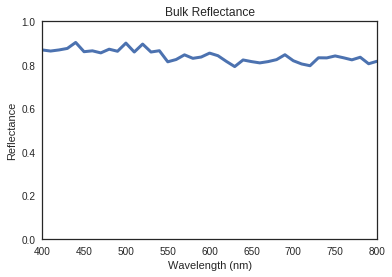

In [22]:
plt.figure()
plt.plot(wavelengths, reflectance_bulk_poly, linewidth = 3)
plt.ylim([0,1])
plt.xlim([400,800])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.title('Bulk Reflectance')
#np.savez('bulk_poly_data/refl_bulk_poly_3_' + str(pdi) + '_' + str(num_radii), 
#        wavelengths = wavelengths, 
#        reflectance = reflectance_bulk_poly)
plt.savefig('reflectance_bulk_poly_pdi0.5.pdf')